### DEM栅格数据分析（昆明）  
DEM数据来源：https://portal.opentopography.org/raster?opentopoID=OTSRTM.082016.4326.1 


In [46]:
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl


In [47]:
path_kunming = 'data/data-section-3/kunming_district_.shp'


In [48]:
kunming_gpd = gpd.read_file(path_kunming)
print(kunming_gpd.total_bounds)
kunming_gpd.head()


[102.171088  24.3852   103.67025   26.541846]


,dt_adcode,dt_name,ct_adcode,ct_name,pr_adcode,pr_name,cn_adcode,cn_name,area,geometry
0,530102,wuhua,530100,昆明市,530000,云南省,100000,中华人民共和国,388,"MULTIPOLYGON (((102.71331 25.13651, 102.71547 ..."
1,530103,panlong,530100,昆明市,530000,云南省,100000,中华人民共和国,864,"POLYGON ((102.71668 25.04473, 102.71663 25.045..."
2,530111,guandu,530100,昆明市,530000,云南省,100000,中华人民共和国,638,"POLYGON ((102.71717 25.03341, 102.71792 25.033..."
3,530112,xishan,530100,昆明市,530000,云南省,100000,中华人民共和国,886,"MULTIPOLYGON (((102.50726 24.86019, 102.50689 ..."
4,530113,dongchuan,530100,昆明市,530000,云南省,100000,中华人民共和国,1866,"POLYGON ((102.80340 26.30291, 102.80537 26.303..."


In [49]:
kunming_gpd_utm48 = kunming_gpd.to_crs(32648)


dem影像投影转换（dem很多分析都需要在投影坐标系下进行）

In [50]:
path_dem = 'data/data-section-5/SRTMGL1Ellip.tif'
path_dem_utm48 = 'data/data-section-5/SRTMGL1_utm48.tif'
# ### gdal命令
# !gdalwarp -s_srs EPSG:4326 -t_srs EPSG:32648 -r bilinear $path_dem $path_dem_utm48



In [103]:
dem_rio = rio.open(path_dem_utm48)
dem_array = dem_rio.read(1)

array([[-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       ...,
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.],
       [-32768., -32768., -32768., ..., -32768., -32768., -32768.]],
      dtype=float32)

<Axes: >

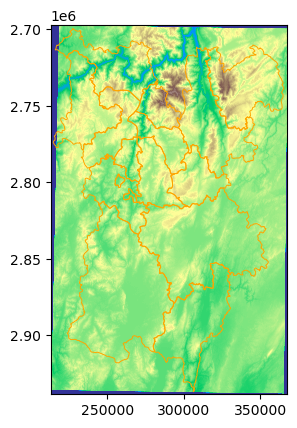

In [52]:
fig, ax = plt.subplots(1,1)
ax.imshow(dem_array, extent=[dem_rio.bounds.left, 
                              dem_rio.bounds.right, 
                              dem_rio.bounds.top, 
                              dem_rio.bounds.bottom],
                              vmin=0,
                              vmax=5000,
                              cmap='terrain'
                              )

kunming_gpd_utm48.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=0.7)



山体阴影显示: 获得照明值影像


In [114]:
path_dem_hillshade = 'data/data-section-5/SRTMGL1_utm48_hillshade.tif'
!gdaldem hillshade $path_dem_utm48 $path_dem_hillshade -az 0 -alt 60 


0...10...20...30...40...50...60...70...80...90...100 - done.


In [115]:
dem_hillshade_rio = rio.open(path_dem_hillshade)
dem_hillshade = dem_hillshade_rio.read(1)
dem_hillshade.shape


(8094, 5176)

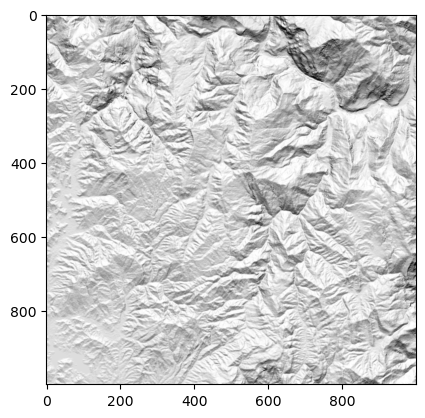

In [116]:
plt.imshow(dem_hillshade[1000:2000, 1000:2000], cmap='gray', vmax=255, vmin=0)


区域统计

In [57]:
from rasterio import mask
result = mask.mask(dem_rio, kunming_gpd_utm48.geometry.to_list(), crop=True, nodata=np.nan)
out_image = result[0]
out_image.shape


(1, 7954, 5053)

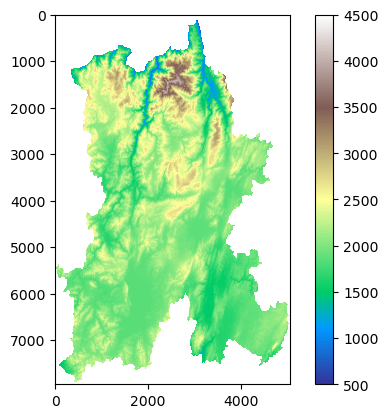

In [58]:
plt.imshow(out_image[0],vmax=4500, vmin=500, cmap='terrain')
plt.colorbar()


In [59]:
print('mean elevation:', np.nanmean(out_image[0]))
print('minimal elevation:', np.nanmin(out_image[0])) 
print('maximal elevation:', np.nanmax(out_image[0]))


mean elevation: 2067.596
minimal elevation: 661.6637
maximal elevation: 4282.058


In [60]:
## 计算每个区平均海拔
def mean_ele(dem_rio, geo_list):
  result = mask.mask(dem_rio, geo_list, crop=True, nodata=np.nan)
  out_image = result[0]
  mean = np.nanmean(out_image[0])
  return mean



In [64]:
mean_ele_dict = {}
mean_ele_dict['kunming'] = mean_ele(dem_rio=dem_rio, geo_list=kunming_gpd_utm48.geometry.to_list())

for i, geo in enumerate(kunming_gpd_utm48.geometry.to_list()):
  mean = mean_ele(dem_rio=dem_rio, geo_list = [geo])
  dt_name = kunming_gpd_utm48['dt_name'][i]
  mean_ele_dict[dt_name] = mean
mean_ele_dict


{'kunming': 2067.596,
 'wuhua': 2046.897,
 'panlong': 2168.4436,
 'guandu': 2026.1119,
 'xishan': 2040.3448,
 'dongchuan': 2170.4463,
 'chengong': 1983.4061,
 'jinning': 2029.8085,
 'fumin': 1995.1049,
 'yiliang': 1800.573,
 'shilin': 1881.1194,
 'sonming': 2007.4069,
 'luquan': 2178.2239,
 'xundian': 2195.8884,
 'anning': 1982.7068}

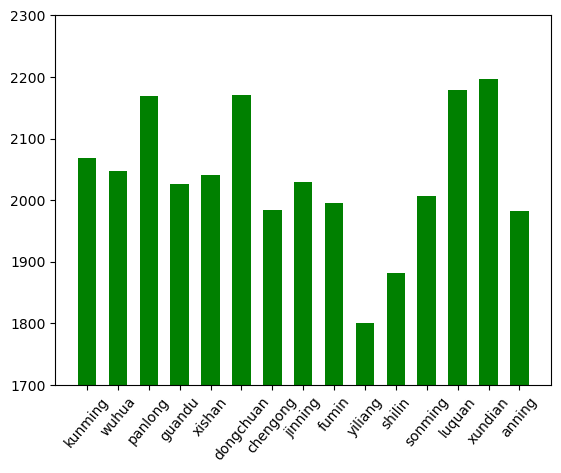

In [66]:
plt.bar(x=mean_ele_dict.keys(), 
            height=mean_ele_dict.values(), 
            width=0.6, 
            color='green');
plt.ylim(1700, 2300);
plt.xticks(rotation=50);


In [67]:
id = np.where(kunming_gpd_utm48['dt_name']=='xundian')[0]
xundian_geo = kunming_gpd_utm48.loc[id]['geometry']
id = np.where(kunming_gpd_utm48['dt_name']=='yiliang')[0]
yiliang_geo = kunming_gpd_utm48.loc[id]['geometry']


In [118]:
xundian_dem = mask.mask(dem_rio, [xundian_geo.values[0]], crop=True, nodata=np.nan)
yiliang_dem = mask.mask(dem_rio, [yiliang_geo.values[0]], crop=True, nodata=np.nan)


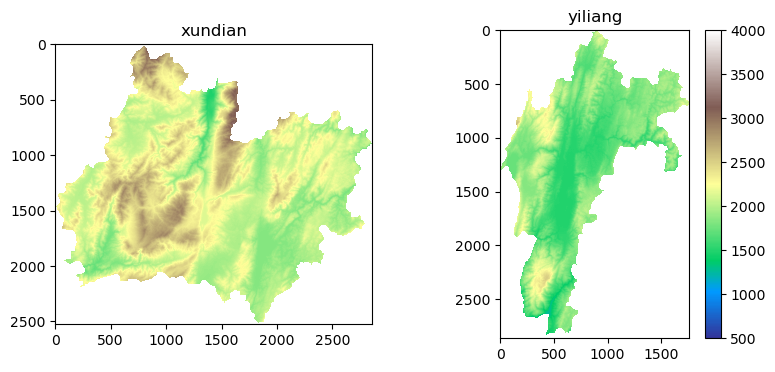

In [122]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
ax0_show = ax[0].imshow(xundian_dem[0][0],vmin=500, vmax=4000, cmap='terrain')
ax[0].set_title('xundian')
ax1_show = ax[1].imshow(yiliang_dem[0][0],vmin=500, vmax=4000, cmap='terrain')
ax[1].set_title('yiliang')
fig.colorbar(ax1_show)


坡度分析


In [70]:
## 坡度
path_dem_slope = 'data/data-section-5/SRTMGL1_utm48_hillshade.tif'
!gdaldem slope $path_dem_utm48 $path_dem_slope


0...10...20...30...40...50...60...70...80...90...100 - done.


In [71]:
dem_slope_rio = rio.open(path_dem_slope)
dem_slope = dem_slope_rio.read(1)
dem_slope.shape


(8094, 5176)

Text(0.5, 1.0, 'xundian slope')

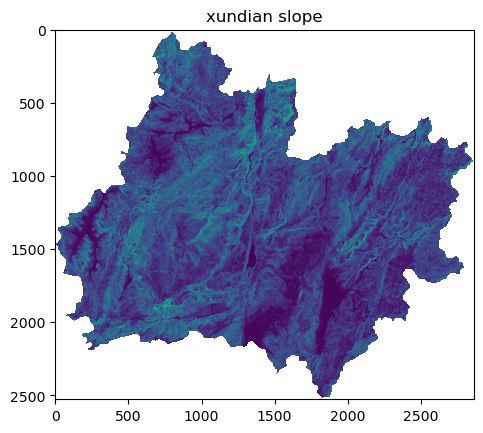

In [129]:
xundian_dem_slope = mask.mask(dem_slope_rio, [xundian_geo.values[0]], crop=True, nodata=np.nan)
plt.imshow(xundian_dem_slope[0][0])
plt.title('xundian slope')


14.825371


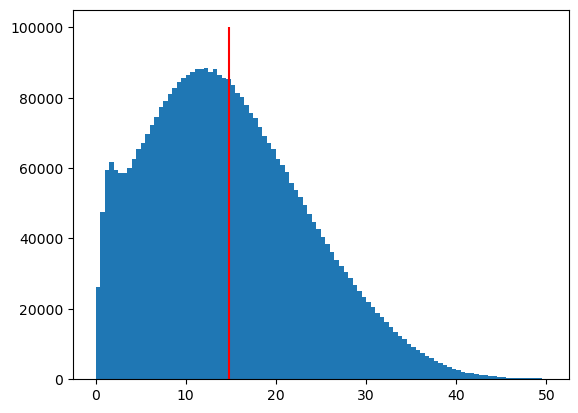

In [99]:
mean = np.nanmean(xundian_dem_slope[0][0])
print(mean)
plt.hist(xundian_dem_slope[0][0].flatten(), bins=100, range=[0, 50]);
plt.vlines(x=mean, ymin=0, ymax=100000, colors='red')

坡向

In [124]:
## 坡向
path_dem_aspect = 'data/data-section-5/SRTMGL1_utm48_aspect.tif'
!gdaldem aspect $path_dem_utm48 $path_dem_aspect


0...10...20...30...40...50...60...70...80...90...100 - done.


In [125]:
dem_aspect_rio = rio.open(path_dem_aspect)
dem_aspect = dem_aspect_rio.read(1)
dem_aspect.shape


(8094, 5176)

Text(0.5, 1.0, 'xundian aspect')

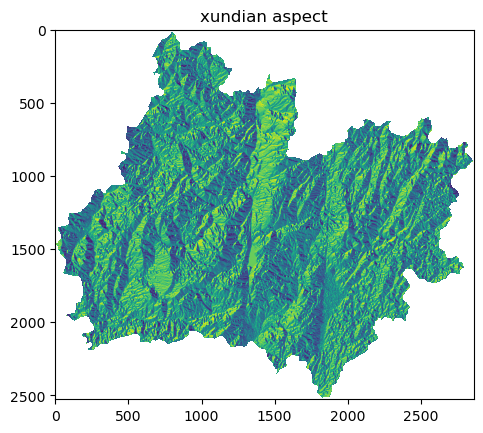

In [130]:
xundian_dem_aspect = mask.mask(dem_aspect_rio, [xundian_geo.values[0]], crop=True, nodata=np.nan)
plt.imshow(xundian_dem_aspect[0][0])
plt.title('xundian aspect')


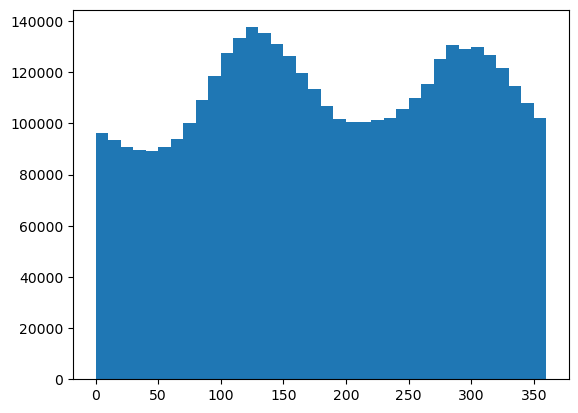

In [268]:
counts, bins, patches = plt.hist(xundian_dem_aspect[0].flatten(), bins=36);


极坐标分析

Text(0.5, 1.0, 'xundian aspect')

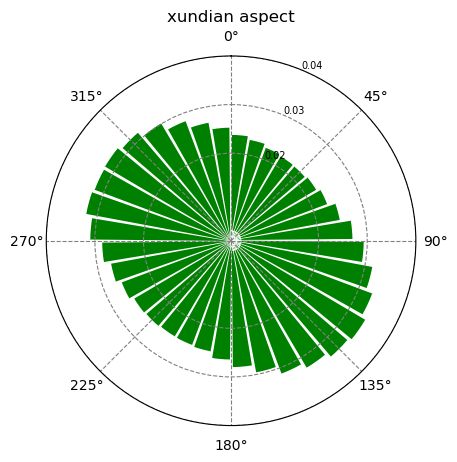

In [274]:
bins_middle_degree = bins[0:-1]+5
bins_middle_rad = 2*np.pi*(bins_middle_degree/360)
width_rad = 2*np.pi/(bins_middle_rad.shape[0]+4)
ax = plt.subplot(projection='polar')
ax.bar(x=bins_middle_rad, 
        height=counts/counts.sum(), 
        width=width_rad, 
        edgecolor='white',
        color='green')
ax.set_ylim([0.002, 0.04]);
ax.set_yticks(ticks=[0.02, 0.03, 0.04], labels=[0.02, 0.03, 0.04], fontsize=7);
ax.grid(True, color='grey', linestyle='--')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)
ax.set_title('xundian aspect')